In [14]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('final_ultimate_log_replaced.csv')

In [15]:
df.head()

,hr_unit_artmp,hr_unit_hum,land_area,forest_area,growing_stock,forest_ratio,avg_growing_stock,u10_mean_ms,v10_mean_ms,wind_dir_deg,...,month_9,month_10,month_11,month_12,cntr_grnds_dstnc,frstn_grnds_dstnc,dspt_req_hr,relax_diff,fire_supesn_hr,wind_speed_mean
0,-1.0,39.0,1635,373,30500,22.81,81.77,2.943493,-1.980742,303.937485,...,0,0,0,0,1.609438,2.484907,5.509388,0.000000,7.277248,1.514662
1,5.0,60.0,1635,373,30500,22.81,81.77,1.894473,0.657474,250.860749,...,0,0,0,0,1.098612,1.609438,5.537334,0.000000,6.749931,1.100383
2,7.0,49.0,1635,373,30500,22.81,81.77,1.958302,-1.082838,298.940291,...,0,0,0,0,1.791759,2.302585,6.467699,0.000000,7.650169,1.174876
3,0.3,48.0,4931,3461,512610,70.18,148.11,2.946276,-2.642112,311.884583,...,0,0,0,0,1.098612,1.791759,6.361302,0.000000,7.653495,1.600889
4,-8.7,36.0,66075,51936,9313181,78.60,179.32,4.143709,1.113212,254.962483,...,0,0,0,1,2.397895,3.295837,6.774224,8.830689,9.638154,1.665939


In [17]:
df.columns

Index(['hr_unit_artmp', 'hr_unit_hum', 'land_area', 'forest_area',
       'growing_stock', 'forest_ratio', 'avg_growing_stock', 'u10_mean_ms',
       'v10_mean_ms', 'wind_dir_deg', 'tp_sum_mm', 'pev_sum_mm',
       'impute_radius', 'ctpv_nm_gangwon', 'ctpv_nm_gyeonggi',
       'ctpv_nm_gyeongnam', 'ctpv_nm_gyeongbuk', 'ctpv_nm_gwangju',
       'ctpv_nm_daegu', 'ctpv_nm_daejeon', 'ctpv_nm_busan', 'ctpv_nm_seoul',
       'ctpv_nm_sejong', 'ctpv_nm_ulsan', 'ctpv_nm_incheon', 'ctpv_nm_jeonnam',
       'ctpv_nm_jeonbuk', 'ctpv_nm_jeju', 'ctpv_nm_chungnam',
       'ctpv_nm_chungbuk', 'wndrct_brng_south', 'wndrct_brng_southeast',
       'wndrct_brng_southwest', 'wndrct_brng_east', 'wndrct_brng_north',
       'wndrct_brng_northeast', 'wndrct_brng_northwest', 'wndrct_brng_west',
       'total_time', 'arrival_time_diff', 'dispatch_time_diff',
       'golden_time_under_50min', 'is_night', 'wspd_bin_1', 'wspd_bin_2',
       'wspd_bin_3', 'wspd_bin_4', 'wspd_bin_5', 'month_1', 'month_2',
       'mo

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
# 파일 경로
CSV_PATH = "final_ultimate_log_replaced.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "fire_supesn_hr"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")


행: 3,361, 열: 66

컬럼명:
 ['hr_unit_artmp', 'hr_unit_hum', 'land_area', 'forest_area', 'growing_stock', 'forest_ratio', 'avg_growing_stock', 'u10_mean_ms', 'v10_mean_ms', 'wind_dir_deg', 'tp_sum_mm', 'pev_sum_mm', 'impute_radius', 'ctpv_nm_gangwon', 'ctpv_nm_gyeonggi', 'ctpv_nm_gyeongnam', 'ctpv_nm_gyeongbuk', 'ctpv_nm_gwangju', 'ctpv_nm_daegu', 'ctpv_nm_daejeon', 'ctpv_nm_busan', 'ctpv_nm_seoul', 'ctpv_nm_sejong', 'ctpv_nm_ulsan', 'ctpv_nm_incheon', 'ctpv_nm_jeonnam', 'ctpv_nm_jeonbuk', 'ctpv_nm_jeju', 'ctpv_nm_chungnam', 'ctpv_nm_chungbuk', 'wndrct_brng_south', 'wndrct_brng_southeast', 'wndrct_brng_southwest', 'wndrct_brng_east', 'wndrct_brng_north', 'wndrct_brng_northeast', 'wndrct_brng_northwest', 'wndrct_brng_west', 'total_time', 'arrival_time_diff', 'dispatch_time_diff', 'golden_time_under_50min', 'is_night', 'wspd_bin_1', 'wspd_bin_2', 'wspd_bin_3', 'wspd_bin_4', 'wspd_bin_5', 'month_1', 'month_2']  ...


,hr_unit_artmp,hr_unit_hum,land_area,forest_area,growing_stock,forest_ratio,avg_growing_stock,u10_mean_ms,v10_mean_ms,wind_dir_deg,...,month_9,month_10,month_11,month_12,cntr_grnds_dstnc,frstn_grnds_dstnc,dspt_req_hr,relax_diff,fire_supesn_hr,wind_speed_mean
0,-1.0,39.0,1635,373,30500,22.81,81.77,2.943493,-1.980742,303.937485,...,0,0,0,0,1.609438,2.484907,5.509388,0.000000,7.277248,1.514662
1,5.0,60.0,1635,373,30500,22.81,81.77,1.894473,0.657474,250.860749,...,0,0,0,0,1.098612,1.609438,5.537334,0.000000,6.749931,1.100383
2,7.0,49.0,1635,373,30500,22.81,81.77,1.958302,-1.082838,298.940291,...,0,0,0,0,1.791759,2.302585,6.467699,0.000000,7.650169,1.174876
3,0.3,48.0,4931,3461,512610,70.18,148.11,2.946276,-2.642112,311.884583,...,0,0,0,0,1.098612,1.791759,6.361302,0.000000,7.653495,1.600889
4,-8.7,36.0,66075,51936,9313181,78.60,179.32,4.143709,1.113212,254.962483,...,0,0,0,1,2.397895,3.295837,6.774224,8.830689,9.638154,1.665939


선택된 피처 수: 62
제외된 컬럼(데이터에 존재했던 항목만): ['fire_supesn_hr', 'relax_diff', 'total_time', 'wind_speed_mean']

최종 데이터 크기: X=(3361, 62), y=(3361,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def optimize_linear_hyperparameters(X, y, model_type="ridge"):
    """
    Ridge/Lasso 하이퍼파라미터 최적화 (5-fold, MSE 기준)
    - 탐색 파라미터: alpha (로그스케일)
    - model_type: 'ridge' 또는 'lasso'
    """
    assert model_type in ("ridge", "lasso"), "model_type은 'ridge' 또는 'lasso'여야 합니다."
    print(f"=== 1단계: {model_type.capitalize()} 하이퍼파라미터 최적화 시작 ===")

    # 파이프라인(표준화 포함)
    if model_type == "ridge":
        estimator = make_pipeline(StandardScaler(with_mean=True), Ridge())
        param_grid = {
            "ridge__alpha": np.logspace(-4, 3, 8)  # 1e-4 ~ 1e3
        }
    else:  # lasso
        estimator = make_pipeline(StandardScaler(with_mean=True), Lasso(max_iter=20000))
        param_grid = {
            "lasso__alpha": np.logspace(-4, 1, 10)  # 1e-4 ~ 10
        }

    # 교차검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # 그리드 서치 (MSE 기준; 출력은 RMSE도 같이 표기)
    gscv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    gscv.fit(X, y)

    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")

    return best_params, gscv.best_estimator_

# 사용 예시
best_params_ridge, best_model_ridge = optimize_linear_hyperparameters(X, y, model_type="ridge")
best_params_lasso, best_model_lasso = optimize_linear_hyperparameters(X, y, model_type="lasso")

=== 1단계: Ridge 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits

최적 하이퍼파라미터: {'ridge__alpha': np.float64(100.0)}
최적 CV MSE: 0.991501 (RMSE=0.995742)
=== 1단계: Lasso 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits

최적 하이퍼파라미터: {'lasso__alpha': np.float64(0.004641588833612782)}
최적 CV MSE: 0.990430 (RMSE=0.995203)


In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def _extract_alpha(best_params, model_type):
    """ridge/lasso용 alpha 키를 유연하게 추출"""
    if best_params is None:
        return None
    if model_type == "ridge":
        for k in ("alpha", "ridge__alpha"):
            if k in best_params:
                return best_params[k]
    if model_type == "lasso":
        for k in ("alpha", "lasso__alpha"):
            if k in best_params:
                return best_params[k]
    return None

def _build_estimator(model_type, best_params):
    """모델 타입과 파라미터에 맞춰 추정기 생성"""
    if model_type == "ols":
        # 필요시 스케일러를 감싸서 사용해도 무방
        return LinearRegression()

    if model_type == "ridge":
        alpha = _extract_alpha(best_params, "ridge")
        if alpha is None:
            alpha = 1.0
        return make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=alpha))

    if model_type == "lasso":
        alpha = _extract_alpha(best_params, "lasso")
        if alpha is None:
            alpha = 0.001
        return make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=alpha, max_iter=20000))

    raise ValueError("model_type은 'ols' | 'ridge' | 'lasso' 중 하나여야 합니다.")

def train_multiple_linear_models(X, y, best_params=None, model_type="ridge",
                                 n_iterations=10, k_folds=5):
    """
    OLS/Ridge/Lasso: (선택한) 최적 파라미터 고정 + KFold의 시드만 변경하며 다회 CV
    - RMSE / MAE / R²의 평균·표준편차를 반복별로 저장
    - best_params:
        * OLS: 사용 안 함
        * Ridge: {'alpha': ...} 또는 {'ridge__alpha': ...}
        * Lasso: {'alpha': ...} 또는 {'lasso__alpha': ...}
    """
    print(f"\n=== 2단계: {model_type.upper()} {n_iterations}회 학습(k={k_folds}) ===")
    results, models = [], []

    X_np = np.asarray(X)
    y_np = np.asarray(y)

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        estimator = _build_estimator(model_type, best_params)

        # 반복마다 서로 다른 셔플 시드로 K-Fold 구성
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42 + i)

        # MSE / R2 / MAE (neg_* → 부호 반전)
        mse_scores = -cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        rmse_scores = np.sqrt(mse_scores)

        r2_scores  = cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='r2', n_jobs=-1
        )
        mae_scores = -cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='neg_mean_absolute_error', n_jobs=-1
        )

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(estimator)  # 주의: cross_val_score 내부에서 학습되므로 여긴 미적합 상태

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

# 실행 예시
# (1) OLS
results_ols, models_ols = train_multiple_linear_models(X, y, best_params=None, model_type="ols")

# (2) Ridge (alpha가 ridge__alpha로 왔을 때도 OK)
best_params_ridge = {"ridge__alpha": 100.0}
results_ridge, models_ridge = train_multiple_linear_models(X, y, best_params_ridge, model_type="ridge")

# (3) Lasso
best_params_lasso = {"alpha": 0.004641588833612782}
results_lasso, models_lasso = train_multiple_linear_models(X, y, best_params_lasso, model_type="lasso")


=== 2단계: OLS 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 0.9970 ± 0.0358
  MAE : 0.7459 ± 0.0220
  R²  : 0.2048 ± 0.0429

--- 2번째 모델 학습 ---
  RMSE: 0.9973 ± 0.0528
  MAE : 0.7461 ± 0.0323
  R²  : 0.2052 ± 0.0512

--- 3번째 모델 학습 ---
  RMSE: 1.0039 ± 0.0487
  MAE : 0.7475 ± 0.0276
  R²  : 0.1934 ± 0.0446

--- 4번째 모델 학습 ---
  RMSE: 0.9950 ± 0.0284
  MAE : 0.7429 ± 0.0126
  R²  : 0.2089 ± 0.0358

--- 5번째 모델 학습 ---
  RMSE: 0.9912 ± 0.0656
  MAE : 0.7426 ± 0.0351
  R²  : 0.2144 ± 0.0347

--- 6번째 모델 학습 ---
  RMSE: 0.9882 ± 0.0340
  MAE : 0.7404 ± 0.0221
  R²  : 0.2185 ± 0.0288

--- 7번째 모델 학습 ---
  RMSE: 0.9926 ± 0.0523
  MAE : 0.7433 ± 0.0341
  R²  : 0.2130 ± 0.0270

--- 8번째 모델 학습 ---
  RMSE: 0.9966 ± 0.0132
  MAE : 0.7439 ± 0.0057
  R²  : 0.2071 ± 0.0198

--- 9번째 모델 학습 ---
  RMSE: 0.9991 ± 0.0275
  MAE : 0.7468 ± 0.0203
  R²  : 0.1999 ± 0.0350

--- 10번째 모델 학습 ---
  RMSE: 0.9929 ± 0.0513
  MAE : 0.7452 ± 0.0279
  R²  : 0.2112 ± 0.0227

=== 2단계: RIDGE 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 


=== 3단계: Ridge 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.9948 ± 0.0051
MAE  평균: 0.7431 ± 0.0021
R²   평균: 0.2086 ± 0.0084

최고 R² 모델: 6번째 (R²=0.2202)
최저 MSE 모델: 6번째 (MSE=0.9757, RMSE=0.9878)


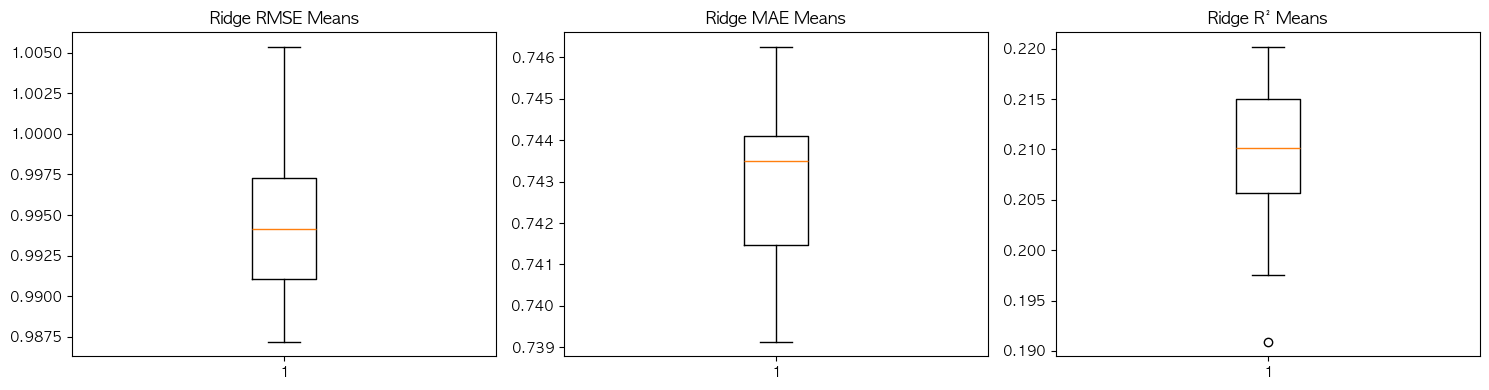

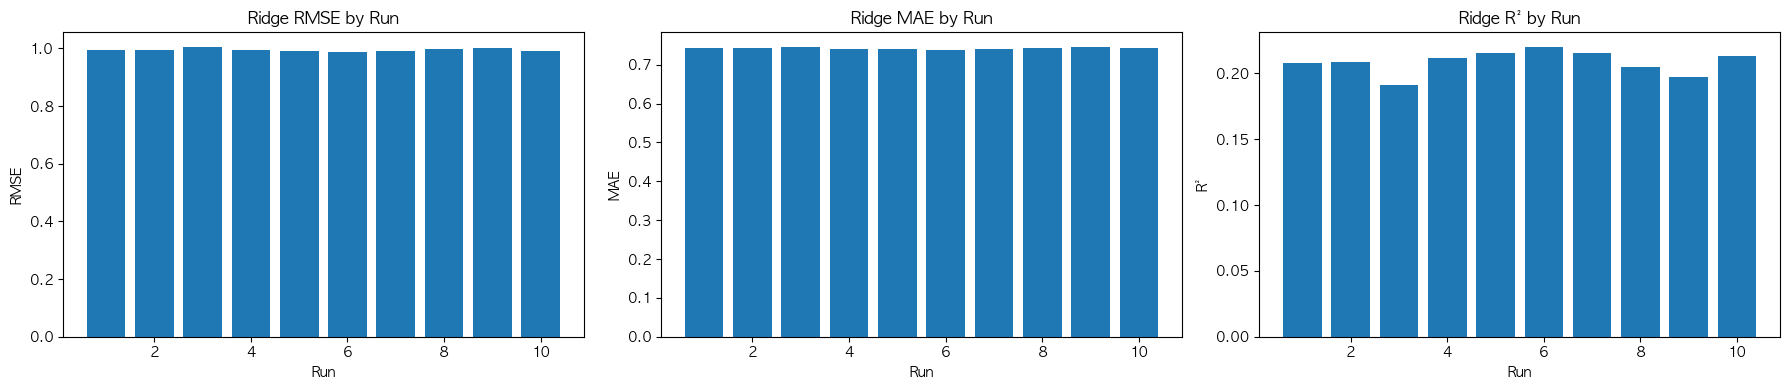


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9930  0.8849 -0.9897
RMSE  0.9930  1.0000  0.8714 -0.9954
MAE   0.8849  0.8714  1.0000 -0.8835
R2   -0.9897 -0.9954 -0.8835  1.0000


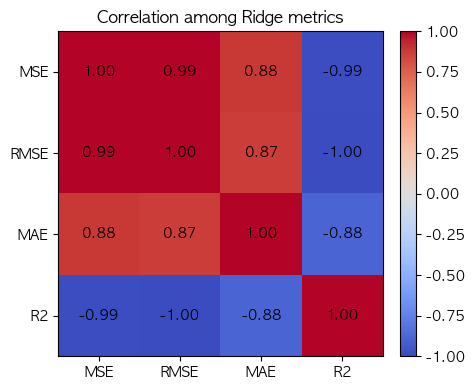


=== 3단계: Lasso 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.9940 ± 0.0042
MAE  평균: 0.7427 ± 0.0019
R²   평균: 0.2100 ± 0.0069

최고 R² 모델: 6번째 (R²=0.2196)
최저 MSE 모델: 6번째 (MSE=0.9765, RMSE=0.9882)


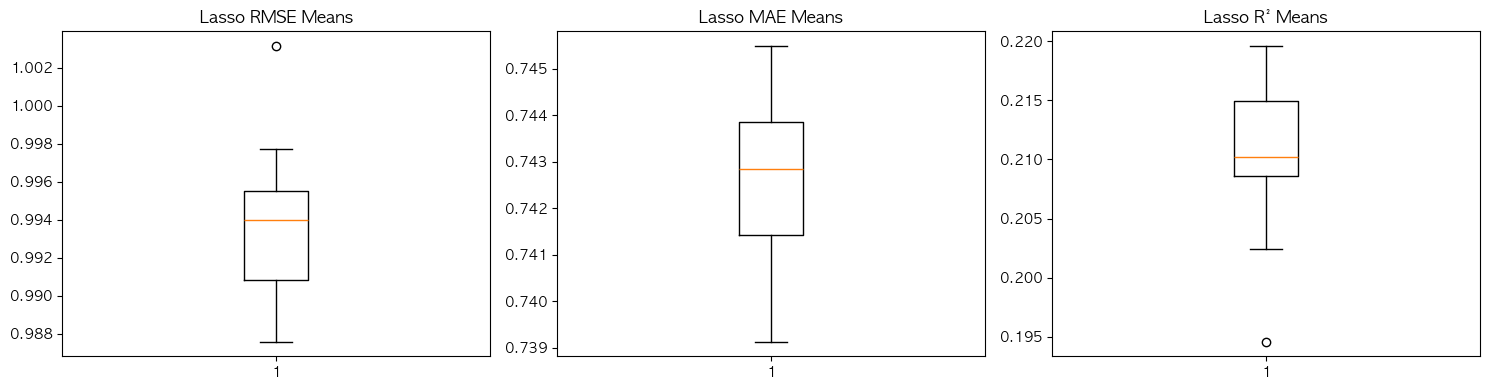

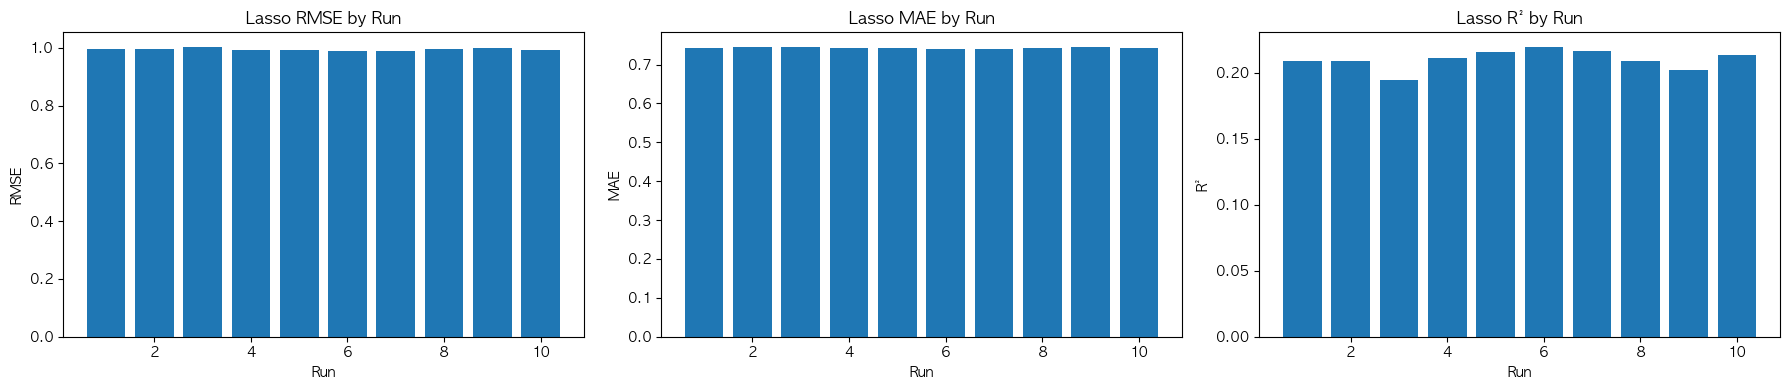


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9901  0.8755 -0.9849
RMSE  0.9901  1.0000  0.8579 -0.9934
MAE   0.8755  0.8579  1.0000 -0.8733
R2   -0.9849 -0.9934 -0.8733  1.0000


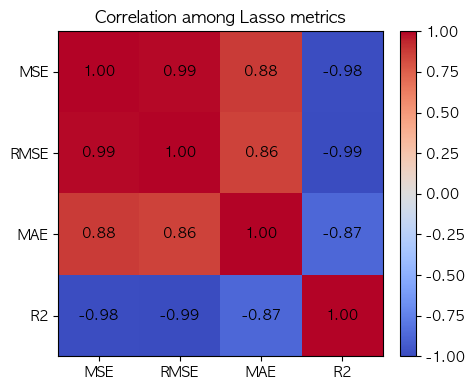


=== 3단계: OLS 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.9954 ± 0.0042
MAE  평균: 0.7445 ± 0.0021
R²   평균: 0.2076 ± 0.0070

최고 R² 모델: 6번째 (R²=0.2185)
최저 MSE 모델: 6번째 (MSE=0.9778, RMSE=0.9888)


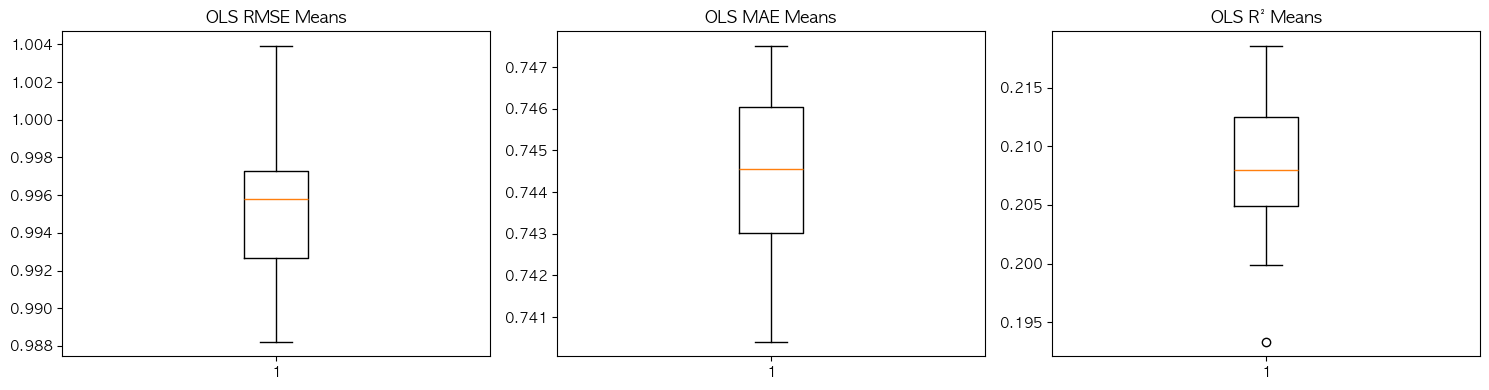

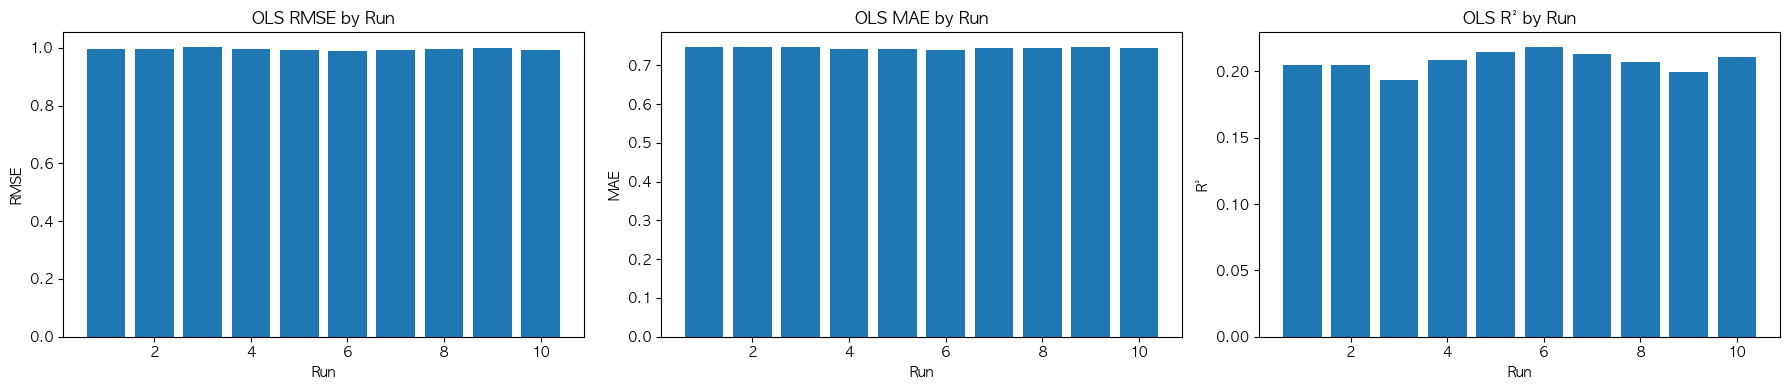


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9896  0.9016 -0.9818
RMSE  0.9896  1.0000  0.8847 -0.9923
MAE   0.9016  0.8847  1.0000 -0.8993
R2   -0.9818 -0.9923 -0.8993  1.0000


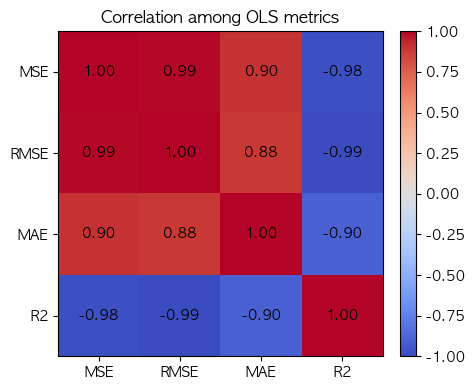

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(results, model_name="Linear Model"):
    """
    results: train_multiple_linear_models()가 반환한 리스트
             각 원소에 'rmse_mean', 'mae_mean', 'r2_mean', 'mse_mean' 키가 있어야 함
    model_name: 출력/그래프에 표시할 모델명 (예: 'OLS', 'Ridge', 'Lasso')
    """
    print(f"\n=== 3단계: {model_name} 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title(f'{model_name} RMSE Means')
    axes[1].boxplot(mae_means);  axes[1].set_title(f'{model_name} MAE Means')
    axes[2].boxplot(r2_means);   axes[2].set_title(f'{model_name} R² Means')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title(f'{model_name} RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title(f'{model_name} MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title(f'{model_name} R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                     color='black', fontweight='bold')
    plt.title(f'Correlation among {model_name} metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

# 사용 예시
best_r2_idx, best_mse_idx = analyze_results(results_ridge, model_name="Ridge")
best_r2_idx, best_mse_idx = analyze_results(results_lasso, model_name="Lasso")
best_r2_idx, best_mse_idx = analyze_results(results_ols,   model_name="OLS")

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


=== OLS 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,ctpv_nm_jeonnam,0.524221,0.524221,1
1,is_night,0.434545,0.434545,1
2,golden_time_under_50min,-0.428798,0.428798,-1
3,month_7,-0.413604,0.413604,-1
4,ctpv_nm_jeonbuk,0.386801,0.386801,1
5,ctpv_nm_ulsan,-0.362190,0.362190,-1
6,dspt_req_hr,0.343617,0.343617,1
7,month_8,0.333889,0.333889,1
8,wspd_bin_5,0.309863,0.309863,1
9,ctpv_nm_daejeon,-0.308356,0.308356,-1


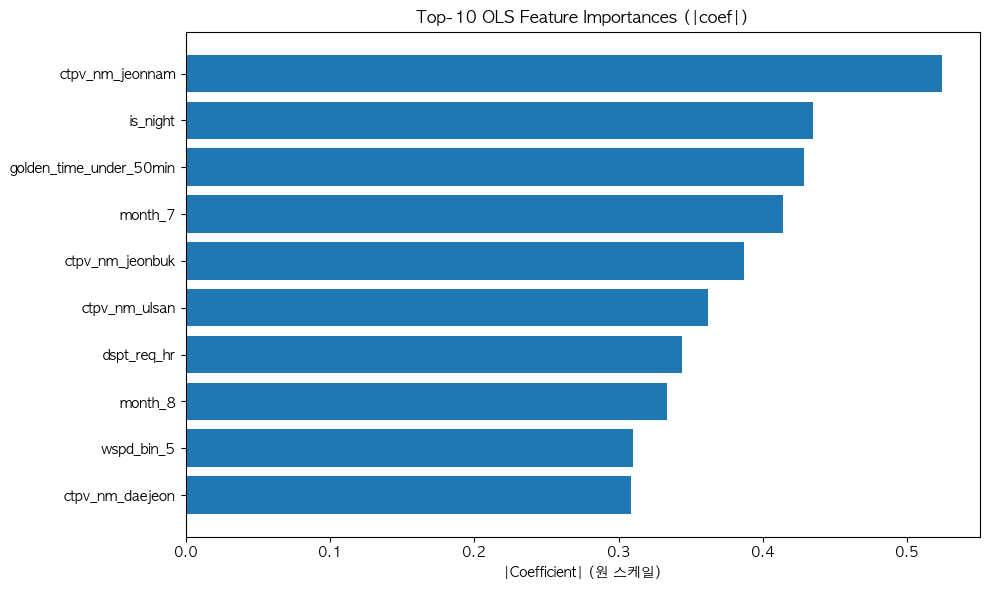


=== Ridge 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,golden_time_under_50min,-0.446656,0.446656,-1
1,ctpv_nm_jeonnam,0.324597,0.324597,1
2,wspd_bin_5,0.317239,0.317239,1
3,month_8,0.305342,0.305342,1
4,ctpv_nm_jeonbuk,0.288435,0.288435,1
5,ctpv_nm_ulsan,-0.283936,0.283936,-1
6,is_night,0.276741,0.276741,1
7,ctpv_nm_gyeonggi,-0.275347,0.275347,-1
8,dspt_req_hr,0.255392,0.255392,1
9,month_7,-0.252915,0.252915,-1


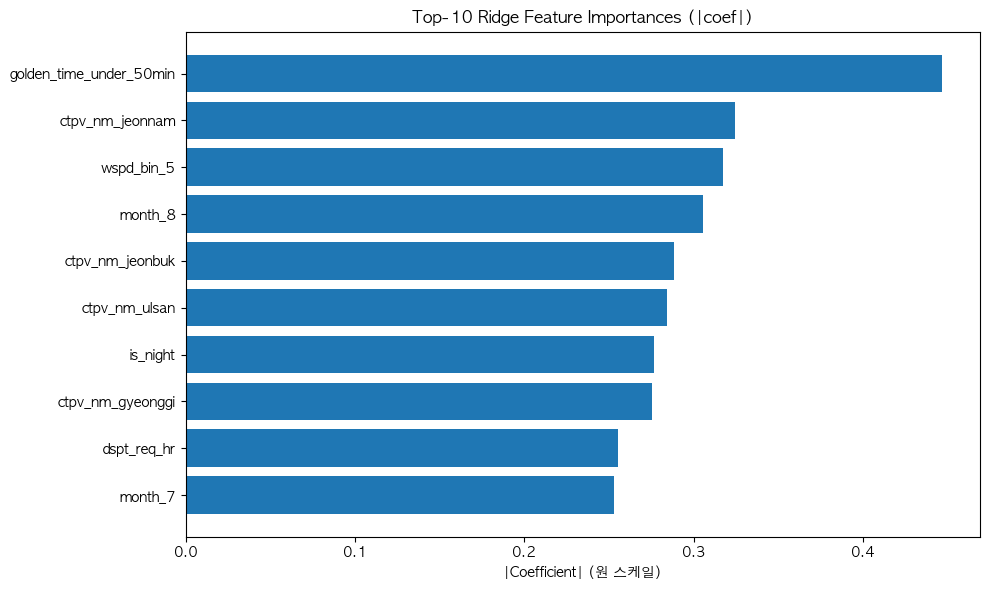


=== Lasso 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,ctpv_nm_jeonnam,0.413114,0.413114,1
1,is_night,0.386568,0.386568,1
2,golden_time_under_50min,-0.368109,0.368109,-1
3,ctpv_nm_ulsan,-0.356102,0.356102,-1
4,dspt_req_hr,0.346000,0.346000,1
5,ctpv_nm_jeonbuk,0.343637,0.343637,1
6,ctpv_nm_gyeonggi,-0.336169,0.336169,-1
7,month_7,-0.320706,0.320706,-1
8,month_8,0.296736,0.296736,1
9,wspd_bin_5,0.270893,0.270893,1


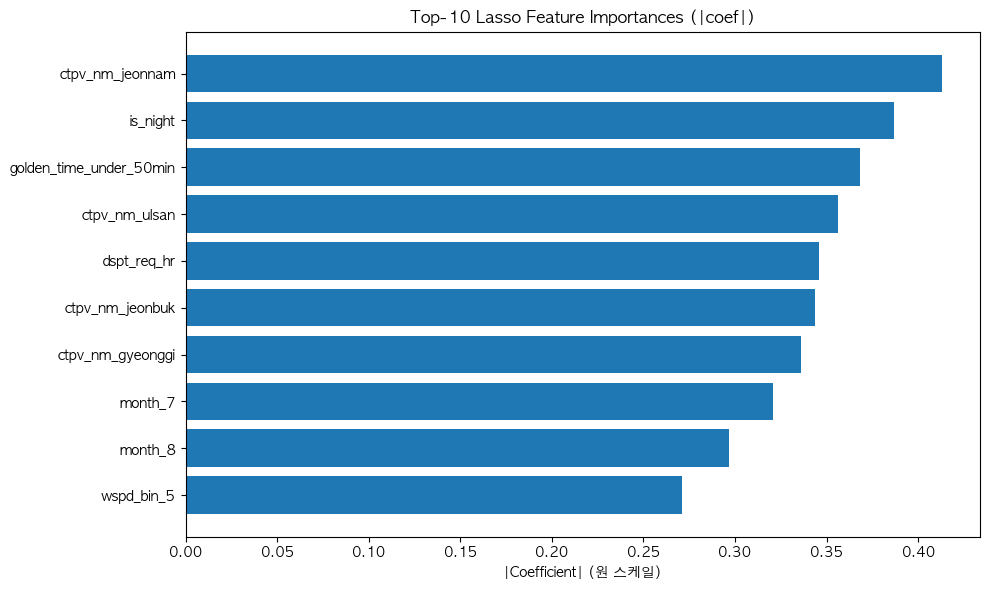

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

def _extract_linear_and_scaler(model):
    """
    모델이 Pipeline(StandardScaler -> LinearModel)인지, 단일 선형모델인지 감지 후
    (linear_model, scaler_or_None)를 반환
    """
    if isinstance(model, Pipeline):
        # 마지막 스텝이 선형모델인지 확인
        last_name, last_est = model.steps[-1]
        if not isinstance(last_est, (LinearRegression, Ridge, Lasso)):
            raise TypeError("파이프라인의 마지막 스텝이 LinearRegression/Ridge/Lasso가 아닙니다.")
        # StandardScaler가 있는지 찾기 (첫 스텝 가정)
        scaler = None
        for name, est in model.steps:
            if hasattr(est, "mean_") and hasattr(est, "scale_"):
                scaler = est
        return last_est, scaler
    else:
        if not isinstance(model, (LinearRegression, Ridge, Lasso)):
            raise TypeError("지원되지 않는 모델 타입입니다. LinearRegression/Ridge/Lasso 또는 그 파이프라인만 지원합니다.")
        return model, None

def _coef_to_original_scale(coef_std, intercept_std, scaler):
    """
    표준화된 X에서 학습한 계수(coef_std, intercept_std)를
    원본 X 스케일로 변환.
      - w_orig = w_std / scale_
      - b_orig = b_std - sum(mean_/scale_ * w_std)
    """
    if scaler is None:
        return coef_std, intercept_std
    scale = scaler.scale_
    mean  = scaler.mean_
    w_orig = coef_std / scale
    b_orig = intercept_std - np.sum((mean / scale) * coef_std)
    return w_orig, b_orig

def linear_feature_importance(best_model, X, top_k=10, model_name="Linear Model"):
    """
    OLS/Ridge/Lasso 모델의 '특성 중요도'를 계수 절댓값 기준으로 계산/시각화.
    - best_model: LinearRegression / Ridge / Lasso 또는 Pipeline(StandardScaler, ...)
    - X: 학습(또는 현재) 특성 DataFrame (컬럼명이 중요)
    - top_k: 상위 표시 개수
    - model_name: 출력용 라벨
    """
    print(f"\n=== {model_name} 특성 중요도 분석 ===")

    assert isinstance(X, pd.DataFrame), "X는 컬럼명이 있는 pandas DataFrame이어야 합니다."
    feature_cols = list(X.columns)

    # 1) 모델/스케일러 추출
    lin, scaler = _extract_linear_and_scaler(best_model)

    # 2) 계수 추출 (표준화 공간에서의 coef_, intercept_)
    coef_std = lin.coef_.ravel()
    intercept_std = lin.intercept_

    # 3) 원본 스케일로 복원
    coef_orig, intercept_orig = _coef_to_original_scale(coef_std, intercept_std, scaler)

    # 4) 중요도 DF (절댓값 기준 내림차순)
    fi = pd.DataFrame({
        "feature": feature_cols,
        "coef": coef_orig,
        "abs_coef": np.abs(coef_orig),
        "sign": np.sign(coef_orig).astype(int)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    print("\n상위 {}개 특성 중요도 (계수 절댓값 기준):".format(top_k))
    display(fi.head(top_k))

    # 5) 시각화
    plt.figure(figsize=(10, 6))
    top = fi.head(top_k).iloc[::-1]  # 위에서 아래로 큰 항목이 보이게 역순
    plt.barh(range(len(top)), top["abs_coef"])
    plt.yticks(range(len(top)), top["feature"])
    plt.xlabel("|Coefficient| (원 스케일)")
    plt.title(f"Top-{top_k} {model_name} Feature Importances (|coef|)")
    plt.tight_layout()
    plt.show()

    return fi, intercept_orig

# =========================
# 사용 예시
# =========================
# (1) OLS 단독 학습 후:
ols = LinearRegression().fit(X, y)
fi_ols, b0_ols = linear_feature_importance(ols, X, top_k=10, model_name="OLS")

# (2) Ridge 파이프라인(표준화 포함) 학습 후:
from sklearn.pipeline import make_pipeline
ridge_pipe = make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=1000.0))
ridge_pipe.fit(X, y)
fi_ridge, b0_ridge = linear_feature_importance(ridge_pipe, X, top_k=10, model_name="Ridge")

# (3) Lasso 파이프라인(표준화 포함) 학습 후:
lasso_pipe = make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=0.004641588833612782, max_iter=20000))
lasso_pipe.fit(X, y)
fi_lasso, b0_lasso = linear_feature_importance(lasso_pipe, X, top_k=10, model_name="Lasso")


=== OLS : 5-Fold CV (로그 스케일 기준) ===
[Fold 1] RMSE=0.9999 | MAE=0.7386 | R²=0.1569
[Fold 2] RMSE=1.0496 | MAE=0.7751 | R²=0.2227
[Fold 3] RMSE=1.0046 | MAE=0.7634 | R²=0.2180
[Fold 4] RMSE=0.9938 | MAE=0.7407 | R²=0.1573
[Fold 5] RMSE=0.9374 | MAE=0.7116 | R²=0.2694

[OLS] === CV 평균(로그 스케일) ===
RMSE(mean±std): 0.9970 ± 0.0358
MAE (mean±std): 0.7459 ± 0.0220
R²  (mean±std): 0.2048 ± 0.0429

[OLS] === 실제 종속변수 통계 (표시 단위 → 분) ===
평균: 189.73 분  |  (3.16 시간, ~3h 9m)
중앙값: 72.52 분  |  (1.21 시간, ~1h 12m)
표준편차: 585.21 분  |  (9.75 시간, ~9h 45m)

[OLS] === 예측 통계 (표시 단위 → 분) ===
예측 평균: 96.62 분  |  (1.61 시간, ~1h 36m)
예측 중앙값: 76.07 분  |  (1.27 시간, ~1h 16m)
평균 차이(예측-실제): -93.11 분  |  (-1.55 시간, ~-2h 26m)
중앙값 차이(예측-실제): 3.55 분  |  (0.06 시간, ~0h 3m)

[OLS] === 원 단위 오차 지표 (참고) ===
RMSE: 696.01 분  |  (11.60 시간, ~11h 36m)
MAE: 152.18 분  |  (2.54 시간, ~2h 32m)
R²  : -0.4145  (역변환 후 R²는 참고용)

=== Ridge : 5-Fold CV (로그 스케일 기준) ===
[Fold 1] RMSE=0.9963 | MAE=0.7357 | R²=0.1629
[Fold 2] RMSE=1.0486 | MAE=0.7737 |

,model,log_RMSE_mean,log_RMSE_std,log_MAE_mean,log_MAE_std,log_R2_mean,log_R2_std,orig_RMSE,orig_MAE,orig_R2
2,Lasso,0.994576,0.035339,0.743530,0.021494,0.208881,0.039774,38382.070892,8982.870692,-0.194900
1,Ridge,0.995085,0.036147,0.744098,0.022111,0.208027,0.041522,39668.412178,9044.393642,-0.276334
0,OLS,0.997041,0.035760,0.745887,0.021985,0.204821,0.042945,41760.824202,9130.517878,-0.414532


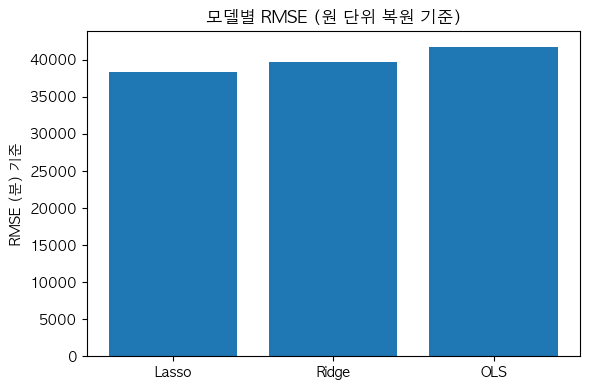

In [27]:
# === OLS / Ridge / Lasso 3개 한 번에 비교 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True       # 타깃이 log1p 변환된 컬럼이면 True (expm1로 역변환)
TIME_UNIT     = "min"      # 출력 단위: 'sec' | 'min' | 'hour'
SHOW_BOTH     = True
N_SPLITS      = 5
RANDOM_STATE  = 42

# 튜닝 완료된 alpha 값 넣으세요
RIDGE_ALPHA = float(np.float64(100.0))
LASSO_ALPHA = float(np.float64(0.004641588833612782))

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."
X_np = np.asarray(X)
y_np = np.asarray(y, dtype=float)

# -----------------------
# 표시/단위 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# 모델 빌더
# -----------------------
def build_estimator(name):
    if name == "OLS":
        return LinearRegression()
    if name == "Ridge":
        return make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=RIDGE_ALPHA))
    if name == "Lasso":
        return make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=LASSO_ALPHA, max_iter=20000))
    raise ValueError("name은 'OLS' | 'Ridge' | 'Lasso' 중 하나여야 합니다.")

# -----------------------
# 단일 모델 평가 
# -----------------------
def evaluate_one(name):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    y_true_list_log, y_pred_list_log = [], []
    rmse_list_log, mae_list_log, r2_list_log = [], [], []

    print(f"\n=== {name} : {N_SPLITS}-Fold CV (로그 스케일 기준) ===")
    for fold_idx, (tr, va) in enumerate(kf.split(X_np), start=1):
        X_tr, X_va = X_np[tr], X_np[va]
        y_tr, y_va = y_np[tr], y_np[va]

        model = build_estimator(name)
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)

        rmse_log = np.sqrt(mean_squared_error(y_va, y_va_pred))
        mae_log  = mean_absolute_error(y_va, y_va_pred)
        r2_log   = r2_score(y_va, y_va_pred)

        rmse_list_log.append(rmse_log)
        mae_list_log.append(mae_log)
        r2_list_log.append(r2_log)

        y_true_list_log.append(y_va)
        y_pred_list_log.append(y_va_pred)

        print(f"[Fold {fold_idx}] RMSE={rmse_log:.4f} | MAE={mae_log:.4f} | R²={r2_log:.4f}")

    # fold 전체 합치기 (로그 스케일)
    y_all_true_log = np.concatenate(y_true_list_log)
    y_all_pred_log = np.concatenate(y_pred_list_log)

    # 원 단위(초) 복원
    if TARGET_IS_LOG:
        y_all_true_sec = np.expm1(y_all_true_log)
        y_all_pred_sec = np.expm1(y_all_pred_log)
    else:
        y_all_true_sec = y_all_true_log
        y_all_pred_sec = y_all_pred_log

    # 통계/지표 (원 단위)
    mean_true    = float(np.mean(y_all_true_sec))
    median_true  = float(np.median(y_all_true_sec))
    std_true     = float(np.std(y_all_true_sec))

    mean_pred    = float(np.mean(y_all_pred_sec))
    median_pred  = float(np.median(y_all_pred_sec))

    rmse_orig = float(np.sqrt(mean_squared_error(y_all_true_sec, y_all_pred_sec)))
    mae_orig  = float(mean_absolute_error(y_all_true_sec, y_all_pred_sec))
    r2_orig   = float(r2_score(y_all_true_sec, y_all_pred_sec))  # 참고용

    print(f"\n[{name}] === CV 평균(로그 스케일) ===")
    print(f"RMSE(mean±std): {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")
    print(f"MAE (mean±std): {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
    print(f"R²  (mean±std): {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")

    print(f"\n[{name}] === 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
    print(show_with_both("평균",     mean_true))
    print(show_with_both("중앙값",   median_true))
    print(show_with_both("표준편차", std_true))

    print(f"\n[{name}] === 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
    print(show_with_both("예측 평균",    mean_pred))
    print(show_with_both("예측 중앙값",  median_pred))
    print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
    print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))

    print(f"\n[{name}] === 원 단위 오차 지표 (참고) ===")
    print(show_with_both("RMSE", rmse_orig))
    print(show_with_both("MAE",  mae_orig))
    print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")

    # 요약 반환
    summary = {
        "model": name,
        "log_RMSE_mean": np.mean(rmse_list_log), "log_RMSE_std": np.std(rmse_list_log),
        "log_MAE_mean":  np.mean(mae_list_log),  "log_MAE_std":  np.std(mae_list_log),
        "log_R2_mean":   np.mean(r2_list_log),   "log_R2_std":   np.std(r2_list_log),
        "orig_RMSE": rmse_orig, "orig_MAE": mae_orig, "orig_R2": r2_orig
    }
    return summary

# -----------------------
# 3개 모델 한 번에 실행
# -----------------------
def run_all_three():
    summaries = []
    for name in ["OLS", "Ridge", "Lasso"]:
        summaries.append(evaluate_one(name))
    df = pd.DataFrame(summaries)

    # 보기 좋게 정렬
    cols = ["model",
            "log_RMSE_mean", "log_RMSE_std",
            "log_MAE_mean",  "log_MAE_std",
            "log_R2_mean",   "log_R2_std",
            "orig_RMSE", "orig_MAE", "orig_R2"]
    df = df[cols].sort_values("orig_RMSE")

    print("\n=== 모델별 요약 표 ===")
    display(df)

    # 간단 비교 그래프 (원 단위 RMSE)
    plt.figure(figsize=(6,4))
    plt.bar(df["model"], df["orig_RMSE"])
    plt.ylabel(f"RMSE ({unit_label(TIME_UNIT)}) 기준")  # 실제 단위는 초→표시단위 환산 안함. 필요시 to_unit()로 변환 가능
    plt.title("모델별 RMSE (원 단위 복원 기준)")
    plt.tight_layout()
    plt.show()

    return df

# =============================
# 사용 예시
# =============================
df_summary = run_all_three()